# Ames House Prices

This notebook includes exploratory data analysis and code for my entry in Kaggle's House Prices competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

I will attempt to predict the sale prices of homes, based upon their features (e.g., lot size, total living area, year of construction, etc.). The training set contains 79 features.

The dataset is the Ames Housing dataset, available on Kaggle, which includes information on 2920 home sales in Ames, Iowa, from 2006 through 2010. Kaggle splits the dataset in half, creating training and test sets of equal size (1460).

In [1]:
# import python modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn import metrics

In [2]:
# read in training set

train = pd.read_csv("housepricestrain.csv")

## Hypothesis: The sale price of a home is positively correlated with (1) its size and (2) how recently it was built.

That seems like a straightforward starting point. Hopefully further analysis of the data will yield further insights into how a home's features affect its sale price.

## Exploratory Data Analysis

### To start, let's plot above-ground living area against sale price for each home in the training set.

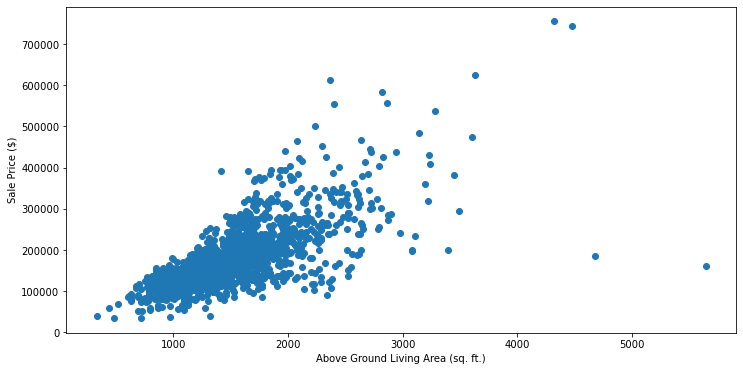

In [3]:
plt.figure(figsize = (12,6))
plt.scatter(x=train['GrLivArea'], y = train['SalePrice'])
plt.xlabel("Above Ground Living Area (sq. ft.)")
plt.ylabel("Sale Price ($)");

As expected, the scatterplot shows an upward trend with sale prices increasing as the size of a home (measured in total square feet of above-ground living area) increases. This makes sense, as larger homes generally sell for more, on average, than smaller homes.

However, there are two notable outliers--both homes that have much more above-ground living area than the other homes in the dataset, but that also sold for less than $200K each. I will remove these outliers from the training set.

In [4]:
# Remove outliers from training set
train=train[train['GrLivArea'] < 4000]

## Target (SalePrice)

The average sale price is 180K. However, as the histogram below shows, the distribution of sale prices is right-skewed, with a number of homes selling for considerably more than the median sale price of 163K.

I address the skewness of our target in the Feature Engineering section below.

In [5]:
train.SalePrice.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

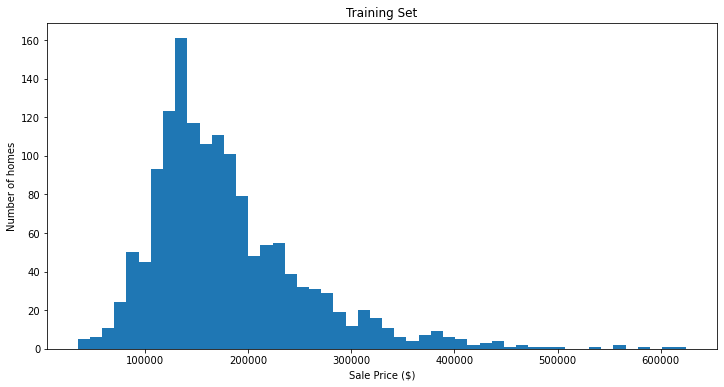

In [6]:
# histogram of training set home sale prices
plt.figure(figsize = (12,6))
plt.hist(train["SalePrice"], bins = 50)
plt.xlabel("Sale Price ($)")
plt.ylabel("Number of homes")
plt.title("Training Set");

## Top 10 Features Correlated with Sale Price

There are 79 features in the training set, covering nearly every aspect of each home. For the sake of brevity, in this notebook, the exploratory data analysis will focus on the 10 features most highly correlated with the target (SalePrice).

In [7]:
# determine the 10 features most correlated with the target (SalePrice)
correlations = train.corr()
ordered_corr = correlations.loc["SalePrice"].sort_values(ascending = False)
top_10 = pd.DataFrame(ordered_corr[0:11])
top_10_cols = list(top_10.index)
data_top10 = train[top_10_cols]
print("Features Most Highly Correlated with Sale Price")
top_10 = top_10.rename(columns = {"SalePrice":"Correlation with SalePrice"})
top_10

Features Most Highly Correlated with Sale Price


,Correlation with SalePrice
SalePrice,1.000000
OverallQual,0.800858
GrLivArea,0.720516
GarageCars,0.649256
TotalBsmtSF,0.646584
GarageArea,0.636964
1stFlrSF,0.625235
FullBath,0.559048
TotRmsAbvGrd,0.537462
YearBuilt,0.535279


As illustrated by the heatmap below, a number of these top 10 features are collinear.

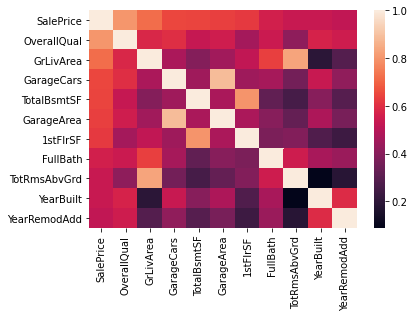

In [8]:
sns.heatmap(data_top10.corr())

#### 1. OverallQual

OverallQual is a categorical variable representing the rating of the overall material and finish of the house. Values range from 1 to 10, with 1 being "very poor" and 10 being "very excellent". 

OverallQual is the feature that most strongly correlates with SalePrice. The overall material and finish most homes in the training set are rated as average, falling in the middle of the distribution.

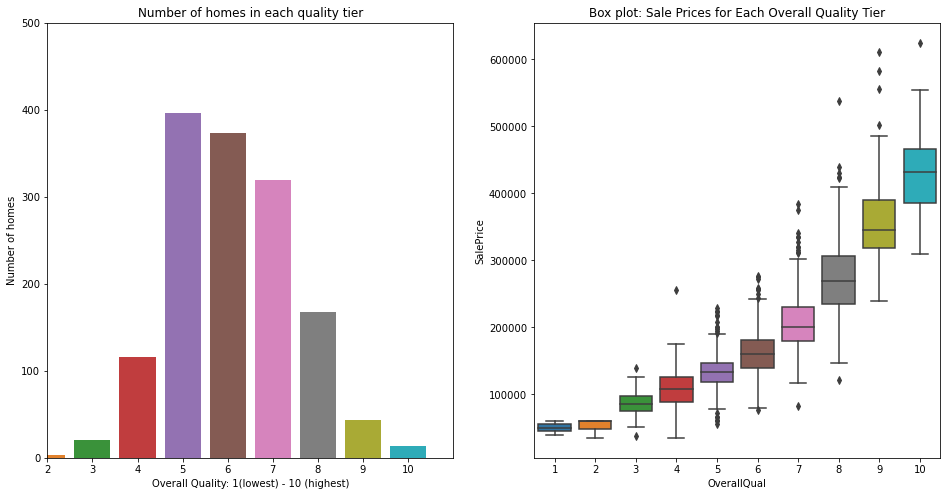

In [9]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.countplot(x = "OverallQual", data = train)
plt.xlabel("Overall Quality: 1(lowest) - 10 (highest)")
plt.ylabel("Number of homes")
plt.title("Number of homes in each quality tier")
plt.xlim([1,10])
plt.ylim([0,500])
plt.subplot(1,2,2)
plt.title("Box plot: Sale Prices for Each Overall Quality Tier")
sns.boxplot(y="SalePrice", x = "OverallQual", data = train);

Sale prices increase as the overall quality of a home increases. 

However, it is notable that each tier covers a significant range of sale prices. For example, the highest-quality homes (Tier 10) sold for between \$300,000 to more than twice that at above \$600,000.

#### 2. GrLivArea

GrLivArea is a numeric variable representing the above grade (ground) living area of a home in square feet. This variable correlates strongly with SalePrice, which is consistent with common sense--all else equal, you'd expect a home with more living area to sell for more than a smaller home.

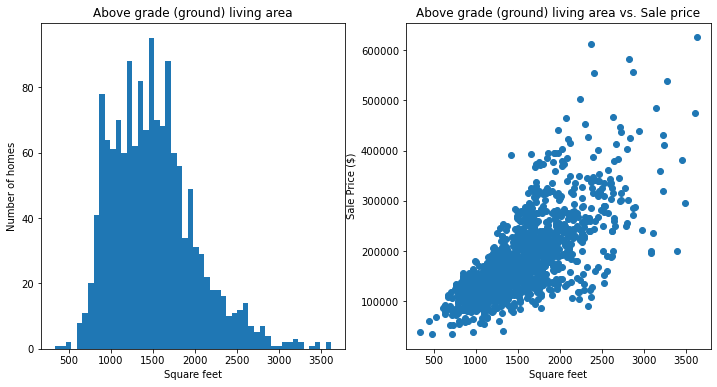

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(train["GrLivArea"], bins = 50)
plt.title("Above grade (ground) living area")
plt.xlabel("Square feet")
plt.ylabel("Number of homes")
plt.subplot(1,2,2)
plt.scatter(train.GrLivArea, train.SalePrice)
plt.xlabel("Square feet")
plt.ylabel("Sale Price ($)")
plt.title("Above grade (ground) living area vs. Sale price");

#### 3 and 4. GarageCars and GarageArea

Two garage-related features correlate highly with SalePrice:

1. GarageCars -- the number of cars that can be stored in a home's garage
2. GarageArea -- the size of a home's garage, measured in square feet

Not surprisingly, these two variables are also highly correlated with each other, as a larger garage enables the owner to store more cars. See heatmap above.

Most homes in the training set have a two-car garage, pretty typical of most American homes, I imagine.

In [11]:
print("Number of homes in training set, by number of cars in garage")
train.GarageCars.value_counts()

Number of homes in training set, by number of cars in garage


2    823
1    369
3    178
0     81
4      5
Name: GarageCars, dtype: int64

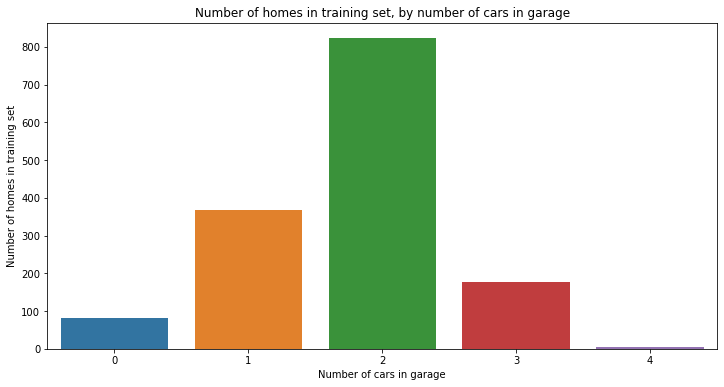

In [12]:
plt.figure(figsize = (12,6))
sns.countplot(train.GarageCars)
plt.xlabel("Number of cars in garage")
plt.ylabel("Number of homes in training set")
plt.title("Number of homes in training set, by number of cars in garage");

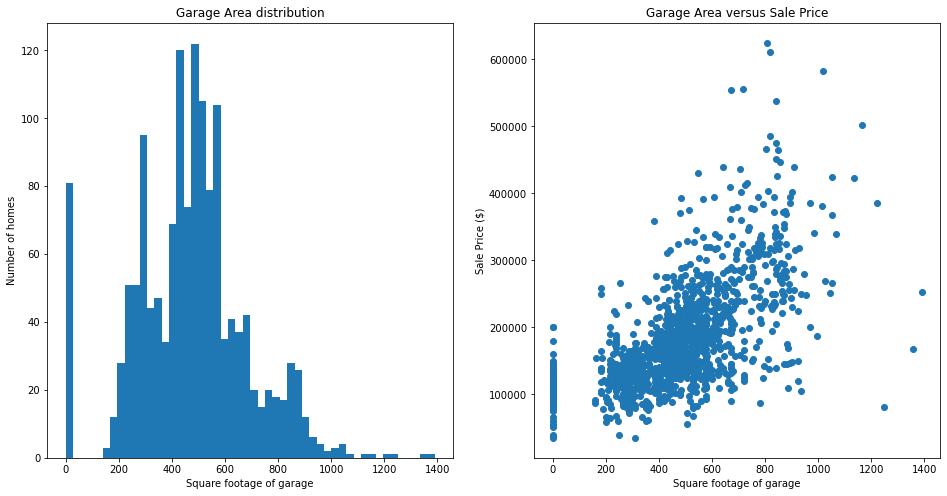

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(train.GarageArea, bins =  50)
plt.ylabel("Number of homes")
plt.xlabel("Square footage of garage")
plt.title("Garage Area distribution")
plt.subplot(1,2,2)
plt.scatter(train.GarageArea, train.SalePrice)
plt.ylabel("Sale Price ($)")
plt.xlabel("Square footage of garage")
plt.title("Garage Area versus Sale Price");

#### 5 and 6. TotalBsmtSF and 1stFlrSF

TotalBsmtSF is a numeric variable measuring the total square feet of a home's basement area. 

1stFlrSF is a numeric variable measuring the first floor square feet of a home.

Besides being highly correlated with SalePrice, they are also highly correlated with each other.

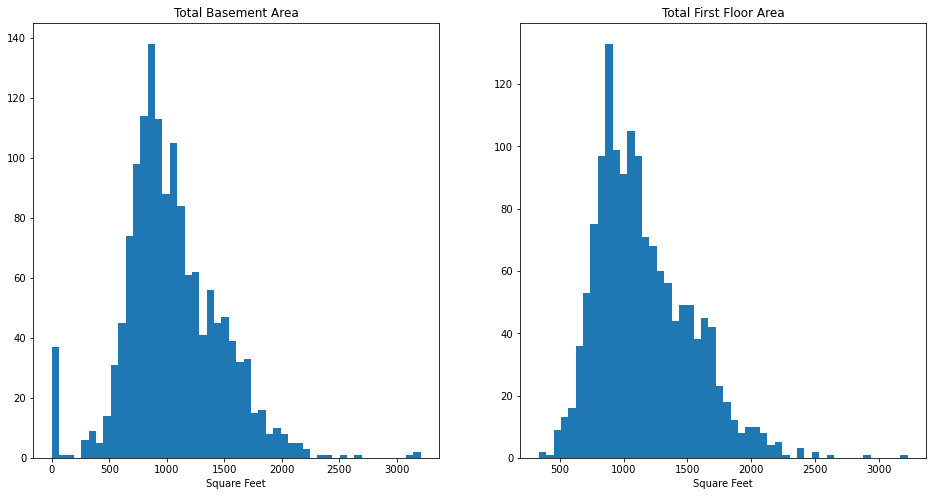

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(train["TotalBsmtSF"],bins = 50)
plt.title("Total Basement Area")
plt.xlabel("Square Feet")
plt.subplot(1,2,2)
plt.hist(train["1stFlrSF"],bins = 50)
plt.title("Total First Floor Area")
plt.xlabel("Square Feet");

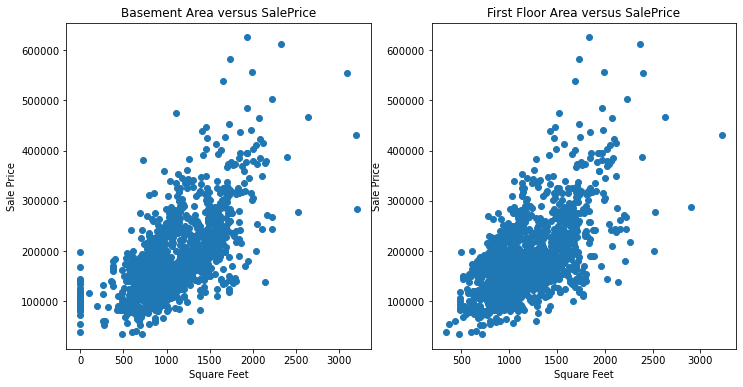

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x = train["TotalBsmtSF"], y = train["SalePrice"])
plt.title("Basement Area versus SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Square Feet")
plt.subplot(1,2,2)
plt.scatter(x = train["1stFlrSF"], y = train["SalePrice"])
plt.title("First Floor Area versus SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Square Feet");

#### 7. FullBath
FullBath is a numeric variable measuring the number of full bathrooms above grade in a home. When I think about my family and the house where I grew up, I am not surprised at all that this feature correlates highly with SalePrice.

In [16]:
print("Number of homes in dataset, by number of full bathrooms above grade")
train.FullBath.value_counts()

Number of homes in dataset, by number of full bathrooms above grade


2    767
1    650
3     30
0      9
Name: FullBath, dtype: int64

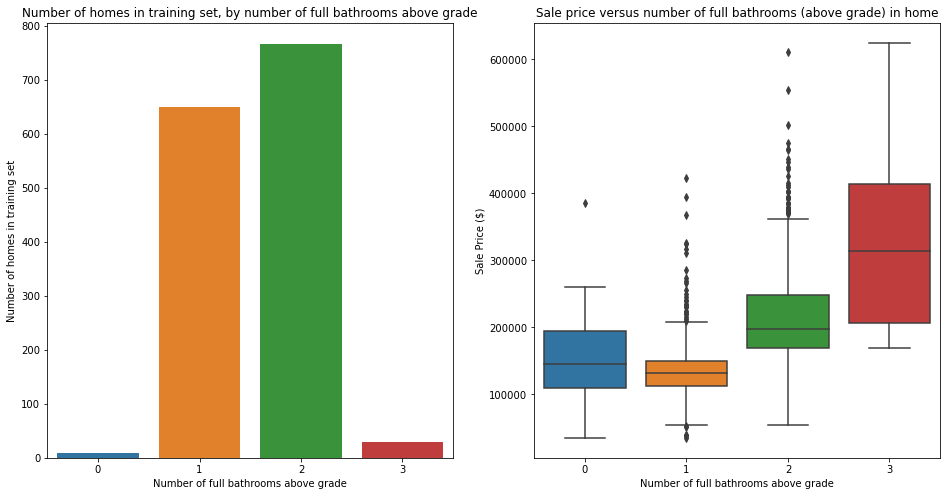

In [17]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.countplot(train.FullBath)
plt.title("Number of homes in training set, by number of full bathrooms above grade")
plt.xlabel("Number of full bathrooms above grade")
plt.ylabel("Number of homes in training set")
plt.subplot(1,2,2)
sns.boxplot(y = "SalePrice", x = "FullBath", data = train)
plt.title("Sale price versus number of full bathrooms (above grade) in home")
plt.xlabel("Number of full bathrooms above grade")
plt.ylabel("Sale Price ($)");

#### 8. TotRmsAbvGrd

TotRmsAbvGrd is a numeric variable representing the total rooms (excluding bathrooms) in a home that are above grade.

As noted in the heatmap above, this feature also correlates highly with a home's above-ground living area. Both of these features represent the total size of a home, and their high correlation with sale price is evidence supporting the hypothesis--i.e, sale prices correlate positively with the size of a home.

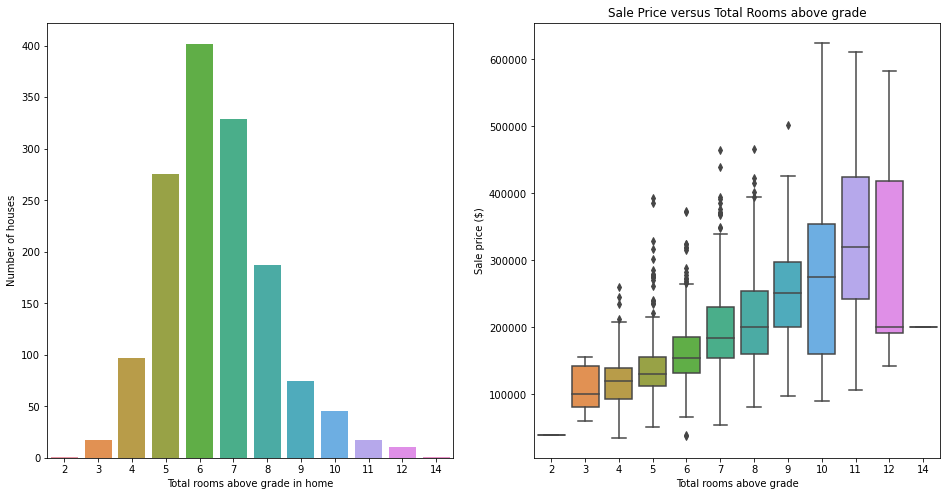

In [18]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.countplot(x = "TotRmsAbvGrd", data = train)
plt.xlabel("Total rooms above grade in home")
plt.ylabel("Number of houses")
plt.subplot(1,2,2)
sns.boxplot(y = "SalePrice", x = "TotRmsAbvGrd", data = train)
plt.title("Sale Price versus Total Rooms above grade")
plt.xlabel("Total rooms above grade")
plt.ylabel("Sale price ($)");

#### 9 and 10. YearBuilt and YearRemodAdd

YearBuilt represents the original construction date of the home. The largest category of homes are those built in 2000 or later, presumably reflecting the housing boom in those years. The scatterplot below provides evidence supporting the hypothesis that newer homes tend to sell for more, on average.

YearRemodAdd represents the remodel date of the home. However, this value is the same as the construction date if no remodeling or additions were made to the home. 

In [19]:
print("Year the oldest home in the dataset was built:", train.YearBuilt.min())
print("Year the newest home in the dataset was built:", train.YearBuilt.max())

Year the oldest home in the dataset was built: 1872
Year the newest home in the dataset was built: 2010


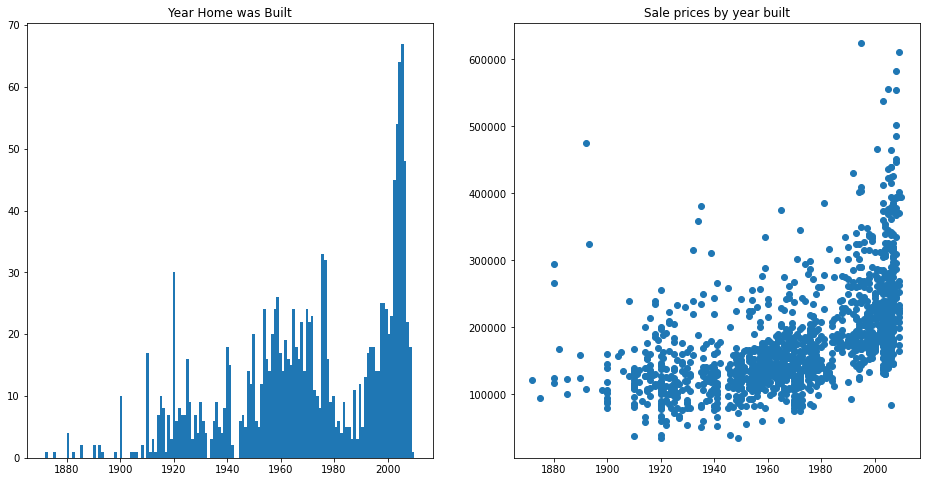

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(train["YearBuilt"], bins= 139)
plt.title("Year Home was Built")
plt.subplot(1,2,2)
plt.scatter(train["YearBuilt"], train["SalePrice"])
plt.title("Sale prices by year built");

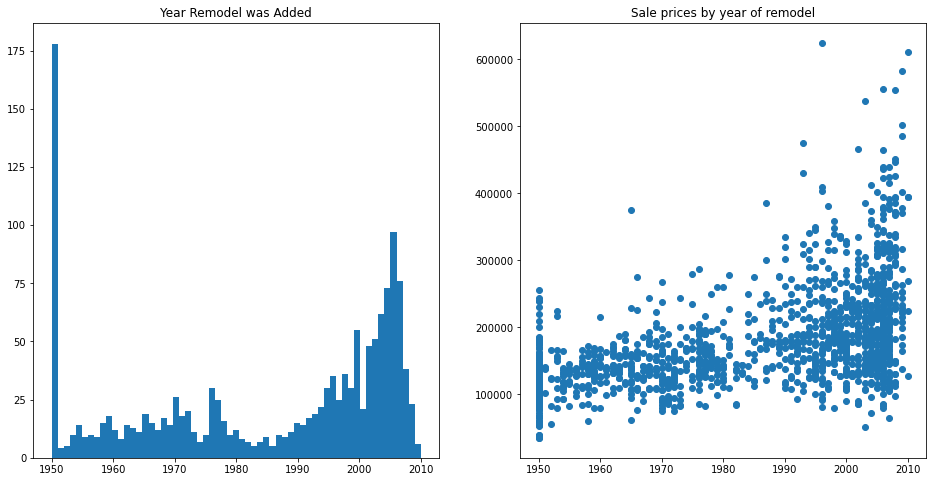

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(train["YearRemodAdd"], bins= 61)
plt.title("Year Remodel was Added")
plt.subplot(1,2,2)
plt.scatter(train["YearRemodAdd"], train["SalePrice"])
plt.title("Sale prices by year of remodel");

## Location, location, location?

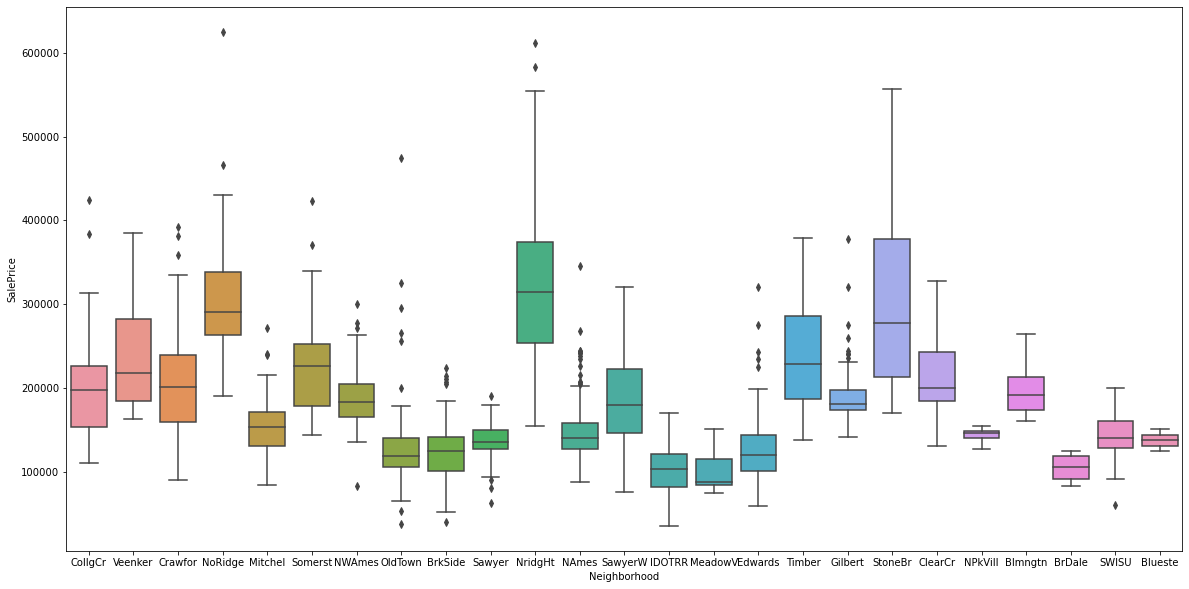

In [22]:
plt.figure(figsize = (20, 10))
sns.boxplot(y="SalePrice", x = "Neighborhood", data = train);

# Cleaning Data

For purposes of cleaning the data and feature engineering, I will combine the training and test sets into one dataframe.

In [23]:
# Save target as y
y = train.SalePrice
# drop target from training set
train = train.drop("SalePrice", axis = 1)
# read in test set
test = pd.read_csv("housepricestest.csv")
# combine train and test into one data frame for data cleaning and feature engineering purposes
data = pd.concat((train,test))

## Missing Values

A number of columns have missing values, which must be addressed.

In [24]:
# get columns with missing values
missing_values = []
for col in data.columns:
    if data[col].isnull().sum()>0:
        missing_values.append(col)
print("Columns with missing values:")
print
for c in missing_values:
    print(c)

Columns with missing values:
MSZoning
LotFrontage
Alley
Utilities
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Electrical
BsmtFullBath
BsmtHalfBath
KitchenQual
Functional
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PoolQC
Fence
MiscFeature
SaleType


### 1. LotFrontage

Several hundred rows are missing values for LotFrontage, a numeric feature measuring the number of feet of the property that faces the street. I replaced these missing values with the median value for LotFrontage in the dataset.

In [25]:
# LotFrontage
# How many missing values are there?
data.LotFrontage.isnull().sum()

486

In [26]:
# Replace missing values with median
lf_median = train.LotFrontage.median()
data.LotFrontage = data.LotFrontage.fillna(lf_median, axis = 0)

In [27]:
# Confirm that no row is missing a LotFrontage value
data.LotFrontage.isnull().sum()

0

### 2. Homes without Garages, Basements, Masonry, etc.

Most of the columns with missing values are categorical features, where the missing value indicates that the property doesn't have that feature. For example, a missing value for GarageType really means that the home didn't have a garage. For these columns, I replaced the missing values with a string, of the form "No[Feature]".

Some rows have missing values for MasVnrArea, which means that the home didn't have any areas of masonry veneer. I replaced these missing values with "1". As discussed below, the distribution of MasVnrArea is skewed, and the "1" for these rows will be log-transformed into "0".

In [28]:
'''
The missing values for these features are all None or a similar value.
Missing numeric values are replaced with 1 for log transformation later.
'''
data.Alley = data.Alley.fillna("NoAlleyAccess", axis = 0)
data.MasVnrType = data.MasVnrType.fillna("None",axis = 0)
data.MasVnrArea = data.MasVnrArea.fillna(1, axis = 0)
data.MasVnrArea.replace(to_replace = 0, value = 1,inplace = True)
data.BsmtQual = data.BsmtQual.fillna("NoBasement",axis = 0)
data.BsmtCond = data.BsmtCond.fillna("NoBasement",axis = 0)
data.BsmtExposure = data.BsmtExposure.fillna("NoBasement",axis = 0)
data.BsmtFinType1 = data.BsmtFinType1.fillna("NoBasement",axis = 0)
data.BsmtFinType2 = data.BsmtFinType2.fillna("NoBasement",axis = 0)
data.FireplaceQu = data.FireplaceQu.fillna("NoFireplace", axis = 0)
data.GarageType = data.GarageType.fillna("NoGarage", axis = 0)
data.GarageYrBlt = data.GarageYrBlt.fillna(0, axis = 0)
data.GarageFinish = data.GarageFinish.fillna("NoGarage", axis = 0)
data.GarageQual = data.GarageQual.fillna("NoGarage",axis = 0)
data.GarageCond = data.GarageCond.fillna("NoGarage",axis = 0)
data.PoolQC = data.PoolQC.fillna("NoPool",axis = 0)
data.Fence = data.Fence.fillna("NoFence",axis = 0)
data.MiscFeature = data.MiscFeature.fillna("NoMiscFeature",axis = 0)
data.BsmtFullBath = data.BsmtFullBath.fillna(0,axis = 0)
data.BsmtHalfBath = data.BsmtHalfBath.fillna(0,axis = 0)
data.GarageCars = data.GarageCars.fillna(0,axis = 0)
data.BsmtFinSF1 = data.BsmtFinSF1.fillna(1, axis = 0)
data.BsmtFinSF2 = data.BsmtFinSF2.fillna(1, axis = 0)
data.TotalBsmtSF = data.TotalBsmtSF.fillna(1, axis = 0)
data.GarageArea = data.GarageArea.fillna(1, axis = 0)

### 3. Other Missing Values (Replace with Mode)

For a number of other categorical features, the most practical approach was to fill in missing values with the mode.

In [29]:
def replace_with_mode(feature):
    mode = data[feature].value_counts().index[0]
    data[feature] = data[feature].fillna(mode, axis = 0)

cat_features_missing_values  = ["MSZoning", "Electrical", "Utilities", "Exterior1st",\
                               "Exterior2nd", "KitchenQual", "Functional", "SaleType",]

for cat in cat_features_missing_values:
    replace_with_mode(cat)

## Feature Engineering

### 1. Skewed Variables: Box-Cox Transformation

The distributions of a number of numeric features were significantly skewed (i.e., skew > 0.5). This is a problem because many machine learning models assume that feature values are distributed normally.

I used the Box-Cox transormation to normalize features whose skew exceeded 0.5. 

In [30]:
# determine skew for numeric features
numeric_columns = ["GrLivArea", "GarageArea", "1stFlrSF", "TotRmsAbvGrd",\
                  "LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
print("Skew of Features in Dataset")
print()
for c in numeric_columns:
    print(c, stats.skew(data[c].dropna()))

Skew of Features in Dataset

GrLivArea 0.977860375775408
GarageArea 0.21776855178283933
1stFlrSF 1.2530114068342657
TotRmsAbvGrd 0.7495786221874003
LotFrontage 1.2219446898075064
LotArea 13.123758076814687
MasVnrArea 2.608913968947732
BsmtFinSF1 0.9741405758036806
BsmtFinSF2 4.142864555009587
BsmtUnfSF 0.9201460899143804
2ndFlrSF 0.8432368612573441
LowQualFinSF 12.080315112009986
WoodDeckSF 1.8482845059023552
OpenPorchSF 2.5292454582791652


In [31]:
# replace zeros with 1 to enable Box-Cox transformation
cols_with_zeros = ["BsmtFinSF1","BsmtFinSF2","GarageArea",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
for c in cols_with_zeros:
    data[c].replace(to_replace = 0, value = 1, inplace = True)

In [32]:
# Box-Cox transformation of features with skews > 0.5
for c in numeric_columns:
    col_name = "bc_" + c
    if stats.skew(data[c].dropna()) > .5:
        try:
            data[col_name] = stats.boxcox(data[c])[0]
        except:
            try:
                for i in range(len(data)):
                    if data.iloc[i][c] <= 0:
                        data.iloc[i][c] = 1
                data[col_name] = stats.boxcox(data[c])[0]
            except:
                pass

/Users/stevenwang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1042: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


Examples of using Box-Cox transformation on GrLivArea (above ground living area) and 1stFlrArea (the square footage of a home's first floor) can be seen in the histograms below.

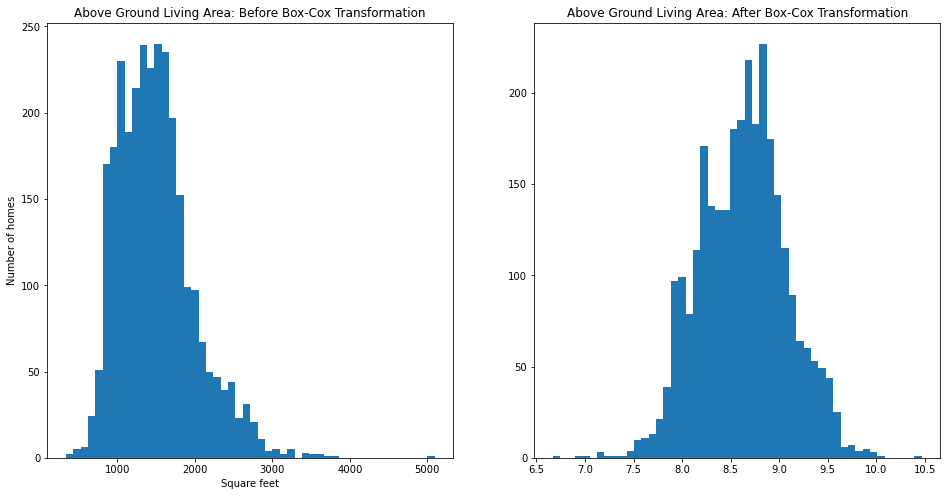

In [33]:
# Before and after: Box-Cox transformation of GrLivArea
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.hist(data.GrLivArea, bins = 50)
plt.title("Above Ground Living Area: Before Box-Cox Transformation")
plt.ylabel("Number of homes")
plt.xlabel("Square feet")
plt.subplot(1,2,2)
plt.hist(data.bc_GrLivArea, bins= 50)
plt.title("Above Ground Living Area: After Box-Cox Transformation");

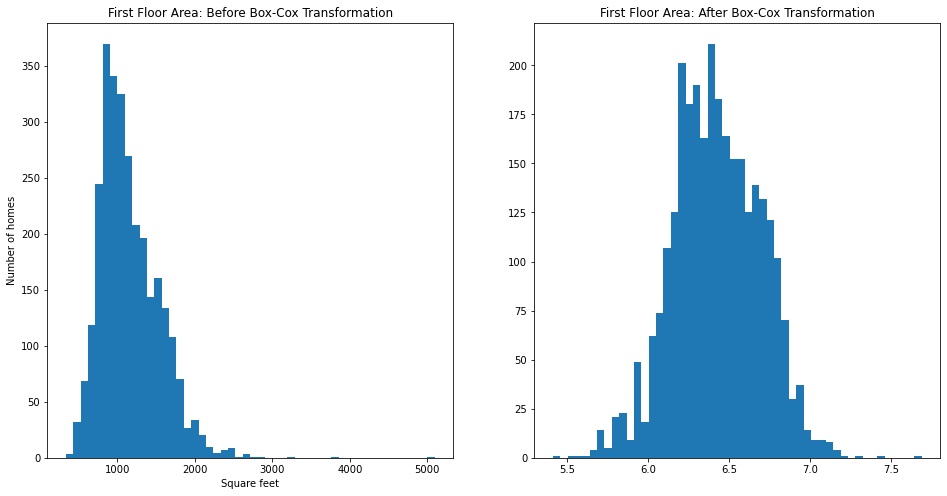

In [34]:
# Before and after: Box-Cox transformation of 1stFlSF
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.hist(data["1stFlrSF"], bins = 50)
plt.title("First Floor Area: Before Box-Cox Transformation")
plt.ylabel("Number of homes")
plt.xlabel("Square feet")
plt.subplot(1,2,2)
plt.hist(data.bc_1stFlrSF, bins = 50)
plt.title("First Floor Area: After Box-Cox Transformation");

In [35]:
# drop old untransformed columns
columns_to_drop = []
numeric_columns = ["GrLivArea", "GarageArea", "1stFlrSF", "TotRmsAbvGrd",\
                  "LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
for c in numeric_columns:
    if stats.skew(data[c].dropna()) > .5:
        columns_to_drop.append(c)
        
for c in columns_to_drop:
    data = data.drop(c, axis = 1)
    
#data.columns

## Create Dummy Variables

The dataset includes many categorical features. I used one-hot encoding to convert these values into dummy variables.

Furthermore, I also dropped the column for "Id", which merely identified each house in the dataset.

In [36]:
feature_list = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',\
               'LandSlope','Condition1','Condition2','BldgType','HouseStyle',\
               'OverallQual','OverallCond','RoofStyle','RoofMatl','Neighborhood',\
               'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',\
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',\
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',\
               'FireplaceQu','GarageType','GarageFinish','GarageQual',\
               'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','YrSold',\
               'SaleType','SaleCondition']
for feature in feature_list:
    dummy = pd.get_dummies(data[feature], prefix = feature, drop_first = True)
    data = pd.concat((data,dummy), axis =1)

In [37]:
data.shape

(2915, 349)

In [38]:
for feature in feature_list:
    data = data.drop(feature, axis = 1)

In [39]:
data = data.drop("Id",axis = 1)

In [40]:

data["MSSubClass_150"].sum()

1

In [41]:
# Seems like there's only one instance of a property in MSSubClass_150, and it's in the training set
# Maybe drop this 
# data.drop("MSSubClass_150",axis = 1, inplace=True)

In [42]:
data.shape

(2915, 300)

In [43]:
data.columns

Index(['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=300)

In [44]:
# final check to see if there are any missing values in the data
for feature in data.columns:
    try:
        if data[feature].isnull().sum() > 0:
            print(feature)
    except:
        pass

bc_BsmtUnfSF


In [45]:
data['bc_BsmtUnfSF'] = data['bc_BsmtUnfSF'].fillna(0,axis = 0)
data["bc_BsmtUnfSF"].isnull().sum()

0

## Define y_log and new test and train sets

In [46]:
y_log = pd.np.log10(y)
new_train = data[:train.shape[0]]
new_test = data[train.shape[0]:]

<ipython-input-46-298c606f8e0c>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  y_log = pd.np.log10(y)


In [47]:
new_train.shape

(1456, 300)

In [48]:
new_test.shape

(1459, 300)

## Cross Validation

In [49]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

## Establish Baseline for Assessing Models

In [50]:
'''
Calculate the root mean squared error (RMSE) if the mean sale price were 
predicted for every row in the training set.'''
mean_SalePrice = y.mean()
squared_errors = 0
for sp in y:
    squared_errors += (mean_SalePrice-sp)**2
print("RMSE, if mean sale price is always predicted:",np.sqrt(squared_errors/len(y)))

RMSE, if mean sale price is always predicted: 76670.24989058504


In [51]:
'''
Calculate the root mean squared logistic error (RMSLE) if the mean sale price were 
predicted for every row in the training set.'''
mean_SalePrice_log = y_log.mean()
squared_errors = 0
for sp in y_log:
    squared_errors += (mean_SalePrice_log-sp)**2
print("RMSLE, if mean sale price is always predicted:",np.sqrt(squared_errors/len(y_log)))

RMSLE, if mean sale price is always predicted: 0.1719562101220656


### As a baseline for evaluating the models below, I calculated the root mean squared error (RMSE) if the mean sale price was always predicted. This value, which turns out to be ~ 76,000, is what each ML model below, at a minimum must beat.

# Linear Regression

As a first step, I will begin by building a straightforward linear regression model, using all columns.

In [52]:
lr_model = LinearRegression()
lr_model.fit(new_train,y_log)

LinearRegression()

In [53]:
# calculate RMSE
preds = lr_model.predict(new_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 78919.50937136528


The straightforward linear regression model has a RMSE exceeding that of the baseline (i.e., the error if we simply predicted the mean sale price every time). Let's see if we can do better with regularization.

## Lasso

There are 300 columns in the training data, and it seems likely that our results are suffering from the Curse of Dimensionality. Lasso (L1) regularization may be helpful here because it will force some of the coefficients for our features to zero. This will enable us to identify the more significant features and improve our predictions.

As a first step, I will use GridSearch to find the best value (roughly to an order of magnitude) for alpha in a Lasso model.

In [54]:
'''
Use GridSearch to find the best value (roughly to an order of magnitude) for alpha
'''
lasso = Lasso(normalize = True)
lasso_parameters = {'alpha': [.000001, .00001, .0001, .001, .01, .1, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_parameters, cv=cv)
lasso_grid.fit(new_train,y_log)
lasso_grid.best_params_

/Users/stevenwang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02146573139882002, tolerance: 0.003490447974410054
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1e-05}

OK, so GridSearch got the best results with an alpha of 10^-5. Let's create a Lasso model, using that as our value for alpha.

In [55]:
lasso2 = Lasso(normalize = True, alpha = .00001)
lasso2.fit(new_train,y_log)

Lasso(alpha=1e-05, normalize=True)

In [56]:
# calculate RMSE
preds = lasso2.predict(new_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 16836.04702175661


### Wow!

RMSE went down from ~78,000, to under 17,000. Lasso definitely produces some promising results. 

Let's take a look at the coefficients.

In [57]:
# Tune alpha further?

In [58]:
lasso3 = Lasso(normalize = True)
lasso3_parameters = {'alpha': [.000001, .000005, .00001, .00005, .0001]}
lasso3_grid = GridSearchCV(lasso3, lasso3_parameters, cv=cv)
lasso3_grid.fit(new_train,y_log)
lasso3_grid.best_params_

/Users/stevenwang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02146573139882002, tolerance: 0.003490447974410054
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1e-05}

In [59]:
lasso4 = Lasso(normalize = True)
lasso4_parameters = {'alpha': [.000005, .0000075, .00001, .000025, .00005]}
lasso4_grid = GridSearchCV(lasso4, lasso4_parameters, cv=cv)
lasso4_grid.fit(new_train,y_log)
lasso4_grid.best_params_

{'alpha': 1e-05}

In [60]:
lasso4 = Lasso(normalize = True)
lasso4_parameters = {'alpha': [.0000075, .00000875, .00001, .0000125, .000025]}
lasso4_grid = GridSearchCV(lasso4, lasso4_parameters, cv=cv)
lasso4_grid.fit(new_train,y_log)
lasso4_grid.best_params_

{'alpha': 1e-05}

In [61]:
lasso4 = Lasso(normalize = True)
lasso4_parameters = {'alpha': [.00000875, .000009375, .00001, .000011125, .0000125]}
lasso4_grid = GridSearchCV(lasso4, lasso4_parameters, cv=cv)
lasso4_grid.fit(new_train,y_log)
lasso4_grid.best_params_

{'alpha': 1e-05}

In [62]:
lasso2Features = list(zip(new_train.columns,lasso2.coef_))
lasso2Features

[('YearBuilt', 0.0008399263085763425),
 ('YearRemodAdd', 0.0003692063720488023),
 ('TotalBsmtSF', 3.977037099596823e-05),
 ('BsmtFullBath', 0.010922092854694814),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.01001543655368737),
 ('HalfBath', 0.008475462204402116),
 ('BedroomAbvGr', -0.0010431043333824748),
 ('KitchenAbvGr', -0.03225380096811898),
 ('Fireplaces', 0.007098147496716743),
 ('GarageYrBlt', 5.023945200719318e-06),
 ('GarageCars', 0.009969266635317574),
 ('GarageArea', 3.0810223347332665e-05),
 ('EnclosedPorch', 2.3481151164072004e-05),
 ('3SsnPorch', 1.5016232120756777e-05),
 ('ScreenPorch', 0.0001065455418583305),
 ('PoolArea', 4.622143054443714e-06),
 ('MiscVal', 3.443244070868222e-07),
 ('bc_GrLivArea', 0.12471768151328388),
 ('bc_1stFlrSF', 0.010631741783298957),
 ('bc_TotRmsAbvGrd', 0.0),
 ('bc_LotFrontage', 0.00047126624364844606),
 ('bc_LotArea', 0.009599561864893828),
 ('bc_MasVnrArea', 0.0),
 ('bc_BsmtFinSF1', 0.001755629240291988),
 ('bc_BsmtFinSF2', 0.00429790632516241

In [63]:
# create list of column names, where the coefficient is greater than zero in the Lasso 2 model
lasso2Cols = [f for f,c in lasso2Features if c != 0]
print("Number of features with a coefficient greater than zero in Lasso 2 model:", len(lasso2Cols))

Number of features with a coefficient greater than zero in Lasso 2 model: 210


Lasso has reduced coefficients for 90 features to zero. Using the remaining 210 features reduces the Curse of Dimensionality, resulting in a markedly lower error. 

Another way of looking at this is as a form of feature selection. By reducing the coefficients for some features to zero, those features have essentially been dropped from our model. Let's see if we can get better results by creating a linear regression model, using only the features kept by our Lasso model.

# Linear Regression, using Lasso features

First, a modified training set is created, where features (columns) are retained only if they had a coefficient greater than zero in the Lasso model.

Then, a linear regression model is created using this modified training set, and its performance is evaluated.

In [64]:
mod_train = new_train[lasso2Cols]
new_lr = LinearRegression()
new_lr.fit(mod_train,y_log)

LinearRegression()

In [65]:
# calculate RMSE
preds = new_lr.predict(mod_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 78919.50937136528


## Ridge

In [66]:
ridge = Ridge(normalize = True)

In [67]:
ridge_parameters = {'alpha': [.000001, .00001, .0001, .001, .01, .1, 1, 10]}
ridge_grid = GridSearchCV(ridge, ridge_parameters, cv=cv)
ridge_grid.fit(new_train,y_log)
ridge_grid.best_params_

{'alpha': 0.1}

In [68]:
ridge2 = Ridge(alpha = 0.1, normalize = True)
ridge2.fit(new_train,y_log)

Ridge(alpha=0.1, normalize=True)

In [69]:
# calculate RMSE
preds = ridge2.predict(new_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 17287.565407794857


In [70]:
# tune alpha further

In [71]:
ridge3 =Ridge(normalize = True)
ridge3_parameters = {'alpha': [.01, .05, .1, 0.5, 1]}
ridge3_grid = GridSearchCV(ridge3, ridge3_parameters, cv=cv)
ridge3_grid.fit(new_train,y_log)
ridge3_grid.best_params_

{'alpha': 0.1}

In [72]:
ridge3 =Ridge(normalize = True)
ridge3_parameters = {'alpha': [.05, .075, .1, 0.25, 0.5]}
ridge3_grid = GridSearchCV(ridge3, ridge3_parameters, cv=cv)
ridge3_grid.fit(new_train,y_log)
ridge3_grid.best_params_

{'alpha': 0.1}

In [73]:
ridge3 =Ridge(normalize = True)
ridge3_parameters = {'alpha': [.075, .0875, .1, 0.125, 0.25]}
ridge3_grid = GridSearchCV(ridge3, ridge3_parameters, cv=cv)
ridge3_grid.fit(new_train,y_log)
ridge3_grid.best_params_

{'alpha': 0.1}

In [74]:
ridge3 =Ridge(normalize = True)
ridge3_parameters = {'alpha': [.0875, .09375, .1, 0.11225, 0.125]}
ridge3_grid = GridSearchCV(ridge3, ridge3_parameters, cv=cv)
ridge3_grid.fit(new_train,y_log)
ridge3_grid.best_params_

{'alpha': 0.11225}

In [75]:
ridge4 = Ridge(normalize = True, alpha = .11225)
ridge4.fit(new_train, y_log)
# calculate RMSE
preds = ridge4.predict(new_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 17400.26220421652


## Random Forest

In [76]:
rf = RandomForestRegressor(n_jobs = 2)
rf_parameters = {"n_estimators":range(100, 550, 50), "max_depth":range(1,15)}
rf_grid = GridSearchCV(rf, rf_parameters, cv=cv)
rf_grid.fit(new_train,y)
rf_grid.best_params_

{'max_depth': 14, 'n_estimators': 150}

In [77]:
rf2 = RandomForestRegressor(n_jobs = 2, n_estimators = 450, max_depth = 13)
rf2.fit(new_train,y_log)

RandomForestRegressor(max_depth=13, n_estimators=450, n_jobs=2)

In [78]:
# calculate RMSE
preds = rf2.predict(new_train)
pred_prices = 10**preds
compare = list(zip(pred_prices,y))
squared_errors = 0
for pred,price in compare:
    squared_errors += (pred - price)**2
mse = squared_errors/len(compare)
print("RMSE:", np.sqrt(mse))

RMSE: 10435.364400340668


In [79]:
fi = list(zip(new_train.columns,rf2.feature_importances_))
sig_features = []
total = 0
for col, imp in fi:
    if imp > .01:
        sig_features.append((col, imp))
        total += imp
        
print(total)
sig_features

0.8426257367730234


[('YearBuilt', 0.15701407168385373),
 ('YearRemodAdd', 0.010887509273476892),
 ('TotalBsmtSF', 0.056890673920990835),
 ('GarageYrBlt', 0.01190011157740228),
 ('GarageCars', 0.05951332206114966),
 ('GarageArea', 0.033785046257703545),
 ('bc_GrLivArea', 0.32899930273494093),
 ('bc_1stFlrSF', 0.0297843916562564),
 ('bc_LotArea', 0.020007113046414376),
 ('bc_BsmtFinSF1', 0.01965962062342402),
 ('ExterQual_TA', 0.08970650620551794),
 ('CentralAir_Y', 0.024478067731893025)]

In [80]:
len(sig_features)

12

In [81]:
most_sig_features = [f for f,s in sig_features]
streamline = new_train[most_sig_features]

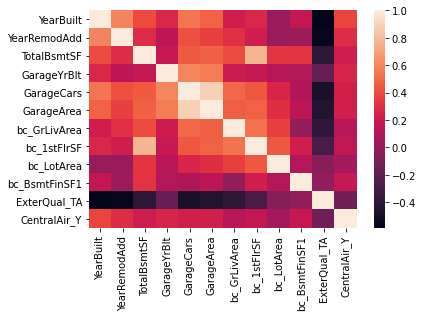

In [82]:

sns.heatmap(streamline.corr())